In [2]:
pip install pyathena

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
from datetime import datetime

In [4]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name= 'analytics'
table_name = 'daily_check'

In [5]:
#Connection to daily_check (based on receiver)
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)

/tmp/ipykernel_3387/2235117015.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101970 entries, 0 to 101969
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   payer         101970 non-null  object 
 1   country       101970 non-null  object 
 2   date          101970 non-null  object 
 3   tx            101970 non-null  int64  
 4   amount        101970 non-null  float64
 5   coupon_count  101970 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 4.7+ MB


In [7]:
#Connection to daily_forex 
forex_table = 'last_daily_forex'
database_name= 'viamericas'
df_rates = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{forex_table};', conn)

/tmp/ipykernel_3387/3034134324.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rates = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{forex_table};', conn)


In [8]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Grouping by 'payer' and 'country' concatenated for this level of granularity
df['payer_country'] = df['payer'] + '_' + df['country']

In [9]:
df = df[df['date'] != '2020-12-31'] # Excluyo el 31-12-2020
df = df[df['date'] <= '2023-10-21'] # Cortamos el dataset hasta el 21/10/2023

In [10]:
df.date.max()

Timestamp('2023-10-21 00:00:00')

In [11]:
def aging_filter(df):
    # Find the last date in the sample
    last_date_sample = df['date'].max()

    # Calculate the limit date, one day before the last date in the sample
    limit_date = last_date_sample - pd.Timedelta(days=1)

    # Find the first and last date per 'payer_country' and calculate total_amount and count
    result = (
        df.groupby('payer_country')
        .agg(
            first_date=('date', 'min'),
            last_date=('date', 'max'),
            total_amount=('amount', 'sum'),
            total_transactions=('tx', 'sum')  # Add this line for total_transactions
        )
        .reset_index()
    )

    # Calculate the 'age_payer' variable accurately using the calculated limit_date
    result['age_payer'] = ((limit_date - result['first_date']).dt.days / 30).round(2)

    # Calculate the 'active_payer' variable
    result['active_time'] = ((result['last_date'] - result['first_date']).dt.days / 30).round(2)

    # Calculate the 'inactive' variable
    result['inactive_time'] = ((limit_date - result['last_date']).dt.days / 30).round(2)

    # Sort the final DataFrame by 'total_amount' from highest to lowest
    result = result.sort_values(by='total_amount', ascending=False)

    # Filter the DataFrame based on conditions and return aging_universe
    aging_universe = result.loc[
        (result.age_payer >= 3) & 
        (result.inactive_time <= 3) & 
        (result.total_amount > 10000) & 
        (result.total_transactions > 50)
    ]

    return aging_universe

In [12]:
df['country'].unique()

array(['EL SALVADOR', 'MEXICO', 'ECUADOR', 'UNITED STATES', 'COLOMBIA',
       'NIGERIA', 'HONDURAS', 'UNITED STATES (ATM & DEPOSITS)',
       'GUATEMALA', 'BRAZIL', 'DOMINICAN REPUBLIC', 'MALI', 'NICARAGUA',
       'LIBERIA', 'INDIA', 'PHILIPPINES', 'BOLIVIA', 'ARGENTINA', 'BENIN',
       'HAITI', 'PERU', 'SENEGAL', 'GHANA', 'SIERRA LEONE', 'CHILE',
       'SPAIN', 'BANGLADESH', 'ITALY', 'TOGO', 'INDONESIA', 'NEPAL',
       'GUINEA', 'GAMBIA, THE', 'GERMANY', 'BELGIUM', 'JAMAICA',
       'CAMBODIA', 'BURKINA FASO', 'CAMEROON', 'URUGUAY',
       "COTE D'IVOIRE (IVORY COAST)", 'THAILAND', 'MALAYSIA', 'PORTUGAL',
       'UNITED KINGDOM', 'SWITZERLAND', 'COSTA RICA', 'FIJI', 'UGANDA',
       'ZAMBIA', 'KENYA', 'SRI LANKA', 'NETHERLANDS', 'LITHUANIA',
       'FRANCE', 'AUSTRIA', 'QATAR', 'GABON', 'ETHIOPIA', 'IRELAND',
       'MAURITANIA', 'PAKISTAN', 'LUXEMBOURG', 'RWANDA', 'TANZANIA',
       'CZECH REPUBLIC', 'ROMANIA', 'CONGO, (CONGO Â– BRAZZAVILLE)',
       'VIETNAM', 'NORWAY', 'CHAD',

In [13]:
# Defining Universe
df = df[df['amount'] != 0] # Excluding 0 (flag A & Flag C), defined in EDA - CHEQUEAR!

df_aging = aging_filter(df) #Filtering 'payer_country' based on Aging notebook
df_filtered = df[df['payer_country'].isin(df_aging['payer_country'])] # Applying aging filters 
df_filtered['date'] = pd.to_datetime(df_filtered['date']).dt.date

/tmp/ipykernel_3387/3736126815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['date']).dt.date


In [14]:
# FOREX - Selecting columns & renaming
df_rates=df_rates.rename(columns={'day': 'date', 'max_feed_price': 'feed_price'})
df_rates=df_rates.loc[:,['date', 'feed_price', 'symbol']]

In [15]:
df_rates

,date,feed_price,symbol
0,2023-04-26,81.9778,USDINR
1,2021-11-29,5.6237,USDBRL
2,2021-11-29,75.1016,USDINR
3,2021-11-29,21.8658,USDMXN
4,2023-04-26,7.8089,USDGTQ
...,...,...,...
5110,2023-05-11,7.8014,USDGTQ
5111,2023-05-11,17.6260,USDMXN
5112,2023-05-11,82.1326,USDINR
5113,2023-05-11,4.9635,USDBRL


In [16]:
def get_closing_prices(data, start_date, end_date):
    # Convert the 'FEED_DATE' column to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Filter by date range
    data_filtered = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

    # Sort by 'FEED_DATE' > chronological order
    data_filtered = data_filtered.sort_values(by='date')

    # Group by 'SYMBOL' and 'FEED_DATE', taking the last value of 'FEED_PRICE'
    data_grouped = data_filtered.groupby(['symbol', pd.Grouper(key='date', freq='D')])['feed_price'].last().reset_index()
    
    return data_grouped

In [17]:
start_date = '2021-01-01'
end_date = '2023-10-21'

rates = get_closing_prices(df_rates, start_date, end_date)

In [18]:
###WE OBTAIN THE LAGS FOR THE EXCHANGE RATE 

def generate_lag_and_variation(df, num_lags):
    # Create columns for each day's lag up to the defined maximum
    for i in range(1, num_lags + 1):
        col_name = f'rate_lag_{i}'
        # Shift the 'feed_price' column grouped by 'symbol'
        df[col_name] = df.groupby('symbol')['feed_price'].shift(i)

    # Calculate the variation columns between consecutive delays
    for i in range(1, num_lags):
        col_name = f'var_rate_lag_{i}'
        # Calculate the difference between consecutive delay columns
        df[col_name] = df[f'rate_lag_{i}'] - df[f'rate_lag_{i + 1}']
    
    return df

In [19]:
rates_number = 14
rates = generate_lag_and_variation(rates, rates_number)
rates['date'] = rates['date'].dt.date #Date format

In [20]:
rates

,symbol,date,feed_price,rate_lag_1,rate_lag_2,rate_lag_3,rate_lag_4,rate_lag_5,rate_lag_6,rate_lag_7,...,var_rate_lag_4,var_rate_lag_5,var_rate_lag_6,var_rate_lag_7,var_rate_lag_8,var_rate_lag_9,var_rate_lag_10,var_rate_lag_11,var_rate_lag_12,var_rate_lag_13
0,USDBRL,2021-01-01,5.1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USDBRL,2021-01-02,5.1934,5.1935,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USDBRL,2021-01-03,5.2008,5.1934,5.1935,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USDBRL,2021-01-04,5.2976,5.2008,5.1934,5.1935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USDBRL,2021-01-05,5.3244,5.2976,5.2008,5.1934,5.1935,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,USDPHP,2023-10-16,56.8185,56.8485,56.8095,56.8227,56.8275,56.8185,56.9342,56.9450,...,0.0090,-0.1157,-0.0108,0.0979,0.1486,-0.0766,0.0307,-0.1480,-0.0374,0.0346
5111,USDPHP,2023-10-17,56.7100,56.8185,56.8485,56.8095,56.8227,56.8275,56.8185,56.9342,...,-0.0048,0.0090,-0.1157,-0.0108,0.0979,0.1486,-0.0766,0.0307,-0.1480,-0.0374
5112,USDPHP,2023-10-18,56.8872,56.7100,56.8185,56.8485,56.8095,56.8227,56.8275,56.8185,...,-0.0132,-0.0048,0.0090,-0.1157,-0.0108,0.0979,0.1486,-0.0766,0.0307,-0.1480
5113,USDPHP,2023-10-19,56.9022,56.8872,56.7100,56.8185,56.8485,56.8095,56.8227,56.8275,...,0.0390,-0.0132,-0.0048,0.0090,-0.1157,-0.0108,0.0979,0.1486,-0.0766,0.0307


In [21]:
rates_dict = {
    'USDBRL': 'BRAZIL', # Bz Real 
    'USDINR': 'INDIA', # Indian Rupia
    'USDGTQ': 'GUATEMALA', #Quetzal 
    'USDMXN': 'MEXICO', #Mx Peso
    'USDPHP': 'PHILIPPINES' # Ph Peso
}

In [22]:
rates['country'] = rates['symbol'].map(rates_dict)

In [23]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5115 entries, 0 to 5114
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   symbol           5115 non-null   object 
 1   date             5115 non-null   object 
 2   feed_price       5115 non-null   float64
 3   rate_lag_1       5110 non-null   float64
 4   rate_lag_2       5105 non-null   float64
 5   rate_lag_3       5100 non-null   float64
 6   rate_lag_4       5095 non-null   float64
 7   rate_lag_5       5090 non-null   float64
 8   rate_lag_6       5085 non-null   float64
 9   rate_lag_7       5080 non-null   float64
 10  rate_lag_8       5075 non-null   float64
 11  rate_lag_9       5070 non-null   float64
 12  rate_lag_10      5065 non-null   float64
 13  rate_lag_11      5060 non-null   float64
 14  rate_lag_12      5055 non-null   float64
 15  rate_lag_13      5050 non-null   float64
 16  rate_lag_14      5045 non-null   float64
 17  var_rate_lag_1

In [24]:
df1 = pd.merge(df_filtered, rates, on=['date', 'country'], how='left')
df1['date'] = pd.to_datetime(df1['date']).dt.date

In [25]:
### EFFECT OF CANCELED TRANSACTIONS ###
database_name= 'analytics'
table2_name = 'daily_sales_count_cancelled_v2'##WE LOAD THE BASE WITH CANCELLATIONS

df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table2_name};', conn)
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2[df2['date'] != '2020-12-31'] # Elimino el registro del 31.12.2020

/tmp/ipykernel_3387/1901381988.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table2_name};', conn)


In [26]:
from sklearn.preprocessing import LabelEncoder

# Grouping by 'payer' and 'country' concatenated for this level of granularity
df2['payer_country'] = df2['payer'] + '_' + df2['country']
# Inicializing LabelEncoder
label_encoder = LabelEncoder()
# Coding ‘PAYER_COUNTRY’ as unique values
df2['payer_country_encoder'] = label_encoder.fit_transform(df2['payer_country'])

In [27]:
# By applying the same aging filter, we can work on the same payer_country universe 
df2 = df2[df2['payer_country'].isin(df_aging['payer_country'])]

In [28]:
def fill_missing_dates(df, start_date, end_date):
    # Create an empty DataFrame with the specified date range
    date_range = pd.date_range(start=start_date, end=end_date)
    df_fill = pd.DataFrame({'date': date_range, 'amount': 0, 'tx_cancelled': 0})
    df_fill['date'] = pd.to_datetime(df_fill['date']).dt.date
    
    # Sort the original DataFrame by 'country', 'payer', and 'date'
    df = df.sort_values(by=['country', 'payer', 'date'])
    
    # Create an empty DataFrame to hold the result
    result_df = pd.DataFrame()

    # Loop through each 'payer_country'
    for payer_country in df['payer_country'].unique():
#        print(payer_country)
        df_aux = df[df['payer_country'] == payer_country]
        # Combining df_aux (payer_country) with df_fill, keeping values from df_aux and filling dates, amount and tx_cancelled 
        merged_df = df_aux.set_index('date').combine_first(df_fill.set_index('date')).reset_index()

        # Fill missing values in 'payer', 'country', 'payer_country', 'payer_country_encoder' columns
        columns_to_fill = ['payer', 'country', 'payer_country', 'payer_country_encoder']
        merged_df[columns_to_fill] = merged_df[columns_to_fill].ffill().bfill()

        result_df = pd.concat([result_df, merged_df], ignore_index=True)

    
    return result_df

In [29]:
#start_date and end_date variables defined previously
start_date = '2021-01-01'
end_date = '2023-10-21'

# Call the function with the specified start_date and end_date
df_full = fill_missing_dates(df2, start_date, end_date)

In [30]:
def generate_tx_lags_and_variation(df, tx_count):
    """
    Generate lag columns for cancelled transactions and their variations.

    Args:
    - df: DataFrame containing transaction data
    - tx_count: Number of periods for lag calculation

    Returns:
    - df: DataFrame with added lag and variation columns
    """
    # Sort the dataset based on country, payer, and date
    df = df.sort_values(by=['country', 'payer', 'date'])

    # Create columns for each day's lag up to the defined maximum
    for i in range(1, tx_count + 1):
        col_name = f'tx_cancelled_lag_{i}'
        # Shift the 'tx_cancelled' column grouped by 'country' and 'payer'
        df[col_name] = df.groupby(['country', 'payer'])['tx_cancelled'].shift(i)

    # Calculate the variation columns between consecutive delays
    for i in range(1, tx_count):
        col_name = f'var_tx_cancelled_lag_{i}'
        # Calculate the difference between consecutive lag columns
        df[col_name] = df[f'tx_cancelled_lag_{i}'] - df[f'tx_cancelled_lag_{i + 1}']

    return df


In [31]:
# Call the function and assign the result back to df2
tx_cancelled_lags = 7
df2 = generate_tx_lags_and_variation(df_full, tx_cancelled_lags)

In [32]:
df2['date'] = df2['date'].dt.date

In [33]:
df2

,date,amount,country,payer,payer_country,payer_country_encoder,tx_cancelled,tx_cancelled_lag_1,tx_cancelled_lag_2,tx_cancelled_lag_3,tx_cancelled_lag_4,tx_cancelled_lag_5,tx_cancelled_lag_6,tx_cancelled_lag_7,var_tx_cancelled_lag_1,var_tx_cancelled_lag_2,var_tx_cancelled_lag_3,var_tx_cancelled_lag_4,var_tx_cancelled_lag_5,var_tx_cancelled_lag_6
0,2021-01-01,0.0,ARGENTINA,ARGENPER,ARGENPER_ARGENTINA,9.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,25.0,ARGENTINA,ARGENPER,ARGENPER_ARGENTINA,9.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-03,0.0,ARGENTINA,ARGENPER,ARGENPER_ARGENTINA,9.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2021-01-04,0.0,ARGENTINA,ARGENPER,ARGENPER_ARGENTINA,9.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,2021-01-05,490.0,ARGENTINA,ARGENPER,ARGENPER_ARGENTINA,9.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133115,2023-10-17,0.0,UNITED STATES (ATM & DEPOSITS),VIAMERICAS USA DEPOSITS,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,287.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133116,2023-10-18,0.0,UNITED STATES (ATM & DEPOSITS),VIAMERICAS USA DEPOSITS,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,287.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133117,2023-10-19,0.0,UNITED STATES (ATM & DEPOSITS),VIAMERICAS USA DEPOSITS,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,287.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133118,2023-10-20,0.0,UNITED STATES (ATM & DEPOSITS),VIAMERICAS USA DEPOSITS,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,287.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df_final = pd.merge(df1,df2, on=['date','payer','country', 'amount'], how='outer')
df_final['date'] = pd.to_datetime(df_final['date'])

In [35]:
df_final.columns

Index(['payer', 'country', 'date', 'tx', 'amount', 'coupon_count',
       'payer_country_x', 'symbol', 'feed_price', 'rate_lag_1', 'rate_lag_2',
       'rate_lag_3', 'rate_lag_4', 'rate_lag_5', 'rate_lag_6', 'rate_lag_7',
       'rate_lag_8', 'rate_lag_9', 'rate_lag_10', 'rate_lag_11', 'rate_lag_12',
       'rate_lag_13', 'rate_lag_14', 'var_rate_lag_1', 'var_rate_lag_2',
       'var_rate_lag_3', 'var_rate_lag_4', 'var_rate_lag_5', 'var_rate_lag_6',
       'var_rate_lag_7', 'var_rate_lag_8', 'var_rate_lag_9', 'var_rate_lag_10',
       'var_rate_lag_11', 'var_rate_lag_12', 'var_rate_lag_13',
       'payer_country_y', 'payer_country_encoder', 'tx_cancelled',
       'tx_cancelled_lag_1', 'tx_cancelled_lag_2', 'tx_cancelled_lag_3',
       'tx_cancelled_lag_4', 'tx_cancelled_lag_5', 'tx_cancelled_lag_6',
       'tx_cancelled_lag_7', 'var_tx_cancelled_lag_1',
       'var_tx_cancelled_lag_2', 'var_tx_cancelled_lag_3',
       'var_tx_cancelled_lag_4', 'var_tx_cancelled_lag_5',
       'var_tx_c

In [36]:
###WE SHOULD KEEP THE VARIABLES THAT HAVE IMPUTED MISSINGS IN AMOUNT AND TX_CANCELLED (DAYS WITHOUT OPERATIONS) BUT KEEP THE MISSINGS IN RATES
df_final=df_final.loc[:,['date', 'payer', 'country', 'amount', 
                         'var_rate_lag_1', 'var_rate_lag_2', 'var_rate_lag_3',
                         'var_rate_lag_4', 'var_rate_lag_5', 'var_rate_lag_6', 'var_rate_lag_7',
                         'var_rate_lag_8', 'var_rate_lag_9', 'var_rate_lag_10',
                         'var_rate_lag_11', 'var_rate_lag_12', 'var_rate_lag_13',
                         'payer_country_encoder','payer_country_y',
                         'var_tx_cancelled_lag_1', 'var_tx_cancelled_lag_2', 'var_tx_cancelled_lag_3',
                         'var_tx_cancelled_lag_4', 'var_tx_cancelled_lag_5', 'var_tx_cancelled_lag_6']]
df_final = df_final.rename(columns={'payer_country_y': 'payer_country'})

In [37]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133120 entries, 0 to 133119
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   date                    133120 non-null  datetime64[ns]
 1   payer                   133120 non-null  object        
 2   country                 133120 non-null  object        
 3   amount                  133120 non-null  float64       
 4   var_rate_lag_1          33694 non-null   float64       
 5   var_rate_lag_2          33665 non-null   float64       
 6   var_rate_lag_3          33637 non-null   float64       
 7   var_rate_lag_4          33608 non-null   float64       
 8   var_rate_lag_5          33581 non-null   float64       
 9   var_rate_lag_6          33553 non-null   float64       
 10  var_rate_lag_7          33525 non-null   float64       
 11  var_rate_lag_8          33498 non-null   float64       
 12  var_rate_lag_9          33469 

In [38]:
### DUMMIES ####

# Weekend indicator (dummy)
df_final['weekend'] = (df_final['date'].dt.dayofweek >= 4).astype(int)

In [39]:
#WE ADD ONE MORE DAY AFTER CHRISTMAS, NEW YEAR'S EVE AND US INDEPENDENCE (BETTER CAPTURES THE DISTURBANCE).
# Special dates list - Format: Month-day 
special_dates_list = [ '07-04', #US independence day 
                      '12-25', #Christmas
                      '05-11' # Mexico & Colombia - Mother's day
                     '01-01', #New Year
                     '01-02',
                     '12-26',
                     '07-05'] 

# Applying format process special_dates function
special_dates_list_processed = [(int(date.split('-')[0]), int(date.split('-')[1])) for date in special_dates_list]

In [40]:
# To check special dates defined by list
def mark_special_dates(row):
    if (row['date'].month, row['date'].day) in special_dates_list_processed:
        return 1
    else:
        return 0

In [41]:
# Marking special dates in df
df_final['special_dates'] = df_final.apply(lambda row: mark_special_dates(row), axis=1)

In [42]:
df_final['amount'].sum()

24303285928.466003

In [43]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133120 entries, 0 to 133119
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   date                    133120 non-null  datetime64[ns]
 1   payer                   133120 non-null  object        
 2   country                 133120 non-null  object        
 3   amount                  133120 non-null  float64       
 4   var_rate_lag_1          33694 non-null   float64       
 5   var_rate_lag_2          33665 non-null   float64       
 6   var_rate_lag_3          33637 non-null   float64       
 7   var_rate_lag_4          33608 non-null   float64       
 8   var_rate_lag_5          33581 non-null   float64       
 9   var_rate_lag_6          33553 non-null   float64       
 10  var_rate_lag_7          33525 non-null   float64       
 11  var_rate_lag_8          33498 non-null   float64       
 12  var_rate_lag_9          33469 

In [44]:
# Impute missings in exogenous variables
df_final.fillna(0, inplace=True)

In [45]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133120 entries, 0 to 133119
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   date                    133120 non-null  datetime64[ns]
 1   payer                   133120 non-null  object        
 2   country                 133120 non-null  object        
 3   amount                  133120 non-null  float64       
 4   var_rate_lag_1          133120 non-null  float64       
 5   var_rate_lag_2          133120 non-null  float64       
 6   var_rate_lag_3          133120 non-null  float64       
 7   var_rate_lag_4          133120 non-null  float64       
 8   var_rate_lag_5          133120 non-null  float64       
 9   var_rate_lag_6          133120 non-null  float64       
 10  var_rate_lag_7          133120 non-null  float64       
 11  var_rate_lag_8          133120 non-null  float64       
 12  var_rate_lag_9          133120

In [53]:
##TOP 20 FORECAST AMOUNTS BETWEEN 01/01/2021 AND 21/10/2023##
total_amount_per_payer =df_final.groupby('payer_country')['amount'].sum()
top_20_payers = total_amount_per_payer.sort_values(ascending=False).head(20)
print(top_20_payers)

payer_country
ELEKTRA (MEXICO)_MEXICO                 6.395528e+09
BANCOPPEL (APPRIZA)_MEXICO              3.345583e+09
BANRURAL (RYT)_GUATEMALA                2.927664e+09
BANCO INDUSTRIAL_GUATEMALA              2.286369e+09
BBVA - BANCOMER (BTS)_MEXICO            6.629850e+08
ENVIOS CON CLABE (APPRIZA)_MEXICO       6.111655e+08
BANORTE (UT)_MEXICO                     4.785500e+08
BANCO DE OCCIDENTE_HONDURAS             4.382700e+08
TELECOMM TELEGRAFOS (APPRIZA)_MEXICO    4.355922e+08
BANCO DE ORO (BDO)_PHILIPPINES          4.347822e+08
BANCO ATLANTIDA_HONDURAS                4.146624e+08
G Y T CONTINENTAL_GUATEMALA             3.814059e+08
BANCO RENDIMENTO_BRAZIL                 3.783719e+08
CARIBE EXPRESS_DOMINICAN REPUBLIC       3.220442e+08
BANCO AGRICOLA_EL SALVADOR              3.168250e+08
FEDECREDITO (RYT)_EL SALVADOR           2.895449e+08
INTERMEX_MEXICO                         2.759044e+08
ELEKTRA (BTS)_HONDURAS                  2.543900e+08
BANCOLOMBIA_COLOMBIA            

In [56]:
df_final.var_rate_lag_13.sum()

2.7098999999999114

In [46]:
df_final.amount.sum()

24303285928.466003

In [49]:
control=df_final.loc[df_final.payer=="ELEKTRA (MEXICO)"]
control.amount.sum()

6395528397.0187

In [50]:
control2=df_final.loc[df_final.payer=="BANCOPPEL (APPRIZA)"]
control2.amount.sum()

3345582592.1968

In [51]:
control3=df_final.loc[df_final.payer=="ENVIOS CON CLABE (APPRIZA)"]
control3.amount.sum()

611165542.8317

In [52]:
control4=df_final.loc[df_final.payer=="BANORTE (UT)"]
control4.amount.sum()

478549983.8973

In [53]:
##mantenemos mismos id_payer que antes##
del df_final['payer_country_encoder']
label_encoder = LabelEncoder()
# Coding ‘PAYER_COUNTRY’ as unique values
df_final['payer_country_encoder'] = label_encoder.fit_transform(df_final['payer_country'])

In [54]:
# Setting DS timeframe

df_21_10 = df_final.loc[df_final.date<'2023-10-21']


In [55]:
df_21_10['amount'].sum()

24254471759.125996

In [56]:
df_21_10.columns

Index(['date', 'payer', 'country', 'amount', 'var_rate_lag_1',
       'var_rate_lag_2', 'var_rate_lag_3', 'var_rate_lag_4', 'var_rate_lag_5',
       'var_rate_lag_6', 'var_rate_lag_7', 'var_rate_lag_8', 'var_rate_lag_9',
       'var_rate_lag_10', 'var_rate_lag_11', 'var_rate_lag_12',
       'var_rate_lag_13', 'payer_country', 'var_tx_cancelled_lag_1',
       'var_tx_cancelled_lag_2', 'var_tx_cancelled_lag_3',
       'var_tx_cancelled_lag_4', 'var_tx_cancelled_lag_5',
       'var_tx_cancelled_lag_6', 'weekend', 'special_dates',
       'payer_country_encoder'],
      dtype='object')

In [57]:
df_21_10.date.max(),df_21_10.date.min()

(Timestamp('2023-10-20 00:00:00'), Timestamp('2021-01-01 00:00:00'))

In [50]:
##Top 10 payers##
#total_amount_per_payer = df_final.groupby('payer_country_encoder')['amount'].sum()
#top_10_payers = total_amount_per_payer.sort_values(ascending=False).head(10)
#print(top_10_payers)

In [51]:
#top_10_payers=[57,29,36,24,38,60,32,20,19,101]
#top_10 = df_final[df_final['payer_country_encoder'].isin(top_10_payers)]

In [52]:
#top_10.country.unique()

In [53]:
#top_10.loc[top_10.country=='HONDURAS']

In [58]:
df_21_10

,date,payer,country,amount,var_rate_lag_1,var_rate_lag_2,var_rate_lag_3,var_rate_lag_4,var_rate_lag_5,var_rate_lag_6,...,payer_country,var_tx_cancelled_lag_1,var_tx_cancelled_lag_2,var_tx_cancelled_lag_3,var_tx_cancelled_lag_4,var_tx_cancelled_lag_5,var_tx_cancelled_lag_6,weekend,special_dates,payer_country_encoder
0,2023-04-24,TELECOMM TELEGRAFOS (APPRIZA),MEXICO,536661.67,0.0244,-0.0335,-0.0687,-0.0085,0.0359,-0.0132,...,TELECOMM TELEGRAFOS (APPRIZA)_MEXICO,22.0,18.0,40.0,-3.0,3.0,-2.0,0,0,101
1,2021-02-27,ELEKTRA (BTS),GUATEMALA,24916.09,-0.0005,-0.0010,-0.0179,-0.0130,-0.0001,0.0000,...,ELEKTRA (BTS)_GUATEMALA,-1.0,4.0,0.0,0.0,-1.0,-5.0,1,0,55
2,2021-10-05,OXXO (TN),MEXICO,15696.39,0.0822,0.0000,-0.2267,0.0188,0.1408,0.1731,...,OXXO (TN)_MEXICO,1.0,3.0,3.0,4.0,1.0,-5.0,0,0,96
3,2023-08-12,TRANSFER DIRECTO,MEXICO,80301.68,-0.0038,-0.0529,-0.0244,0.0660,0.0265,0.0080,...,TRANSFER DIRECTO_MEXICO,8.0,-4.0,5.0,-5.0,-1.0,10.0,1,0,105
4,2021-12-31,BANCO DE GUAYAQUIL,ECUADOR,15688.22,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,BANCO DE GUAYAQUIL_ECUADOR,-6.0,7.0,-2.0,3.0,0.0,-2.0,1,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133114,2023-10-16,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,122
133115,2023-10-17,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,122
133116,2023-10-18,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,122
133117,2023-10-19,VIAMERICAS USA DEPOSITS,UNITED STATES (ATM & DEPOSITS),0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & D...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,122


In [61]:
df_final.date.min(),df_final.date.max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2023-10-21 00:00:00'))

In [67]:
df_final_last_year=df_final.loc[df_final.date>='2023-10-21']

In [ ]:
##WE GENERATED 4 DATASETS OF 1 YEAR OF DATA: 1) OCT-23 OCT-22 2)JUL 23-JUL22 3)APR23-ABR22

In [144]:
df_final_last_year=df_final.loc[df_final.date>='2023-10-21']
df_final_last_year_jul=df_final.loc[(df_final.date>='2022-07-01') & (df_final.date<='2023-07-01') ]
df_final_last_year_apr=df_final.loc[(df_final.date>='2022-04-01') & (df_final.date<='2023-04-01') ]

In [ ]:
###WE START WITH THE CUT-OFF FROM OCTOBER 23 TO OCTOBER 22##

In [68]:
df_final_last_year.date.min()

Timestamp('2023-10-21 00:00:00')

In [165]:
##WEIGHT  OF EACH PAYER (10/21/23-21/10/22)##
# Calculate the total amount
total_amount = df_final_last_year['amount'].sum()

# Calculate the participation of each country
df_final_last_year['participation'] = df_final_last_year['amount'] / total_amount

# Group and sum the amount by country
total_amount_per_payer = df_final_last_year.groupby('payer_country')['amount'].sum()

# Get the top 40 payers
top_40_payers = total_amount_per_payer.sort_values(ascending=False).head(40)

# Calculate the percentage of each country relative to the total amount
percentage_of_total = (top_40_payers / total_amount) * 100

# Calculate the cumulative sum of participations
cumulative_participation = percentage_of_total.cumsum()

# Create a DataFrame with the amounts, percentages, and cumulative participations
top_40_df = pd.DataFrame({'amount': top_40_payers, 
                          'percentage_of_total': percentage_of_total,
                          'cumulative_participation': cumulative_participation})

top_40_df['payer_country'] =top_40_df.index
top_40_df['country_name'] = top_40_df['payer_country'].str.split('_').str[1]

#print(top_40_df)

/tmp/ipykernel_339/1244808166.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_last_year['participation'] = df_final_last_year['amount'] / total_amount


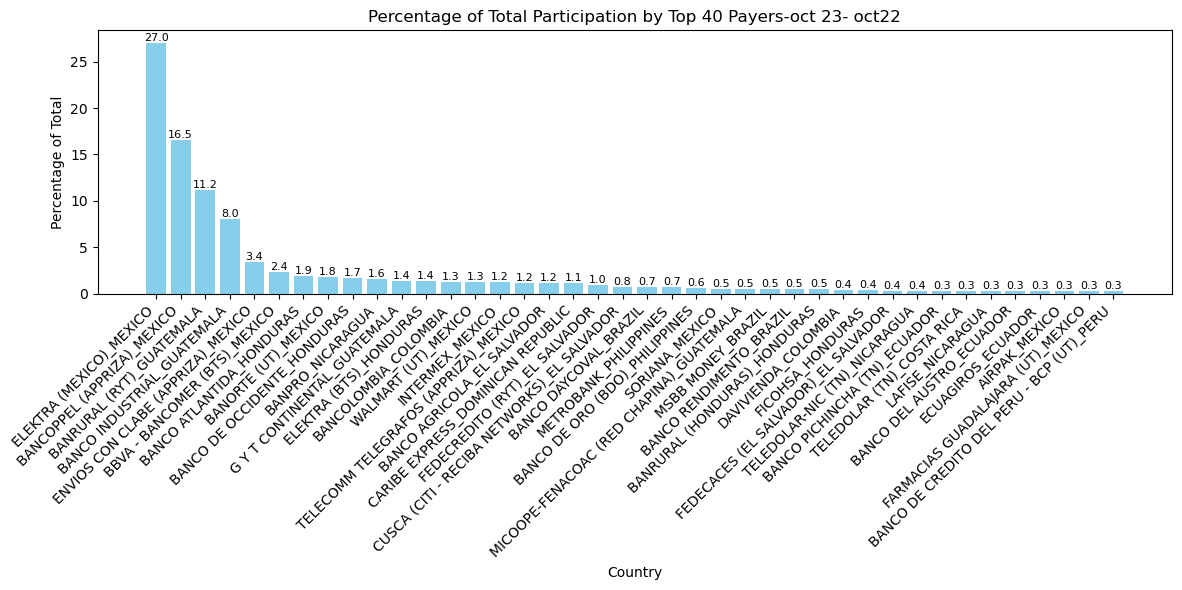

In [166]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_40_df['payer_country'], top_40_df['percentage_of_total'], color='skyblue')
plt.title('Percentage of Total Participation by Top 40 Payers-oct 23- oct22')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=8)

plt.tight_layout()
plt.show()

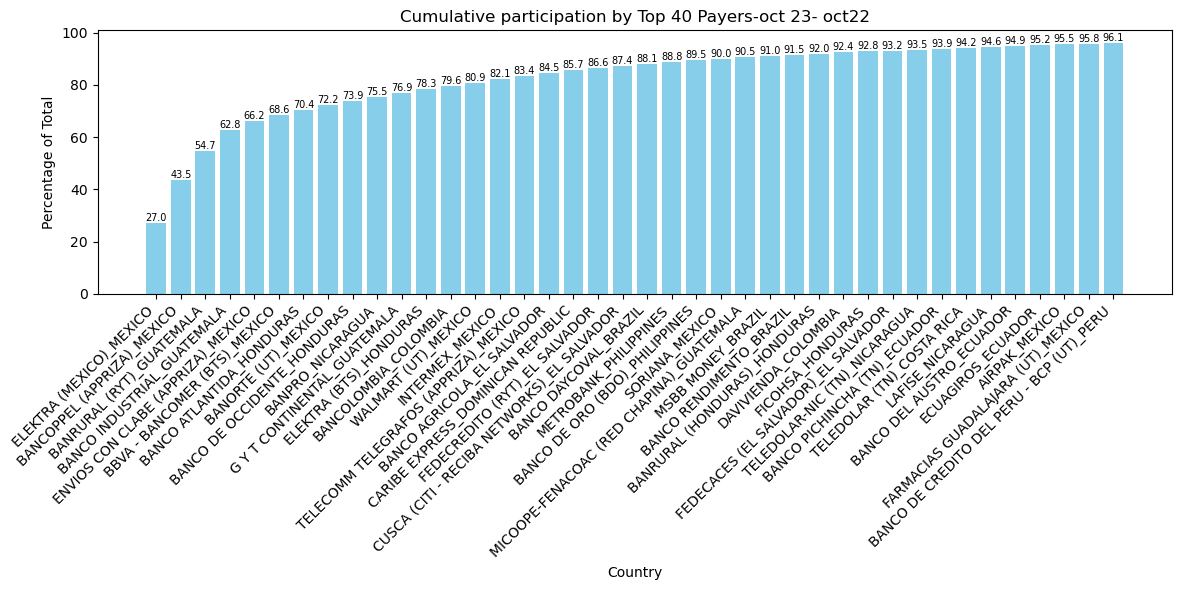

In [167]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_40_df['payer_country'], top_40_df['cumulative_participation'], color='skyblue')
plt.title('Cumulative participation by Top 40 Payers-oct 23- oct22')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=7)

plt.tight_layout()
plt.show()

In [136]:
##TOP 10 COUNTRIES

In [168]:
# Calculate the total amount of business
total_business_amount = df_final_last_year['amount'].sum()

# Calculate the participation of each country
df_final_last_year['country_participation'] = df_final_last_year.groupby('country')['amount'].transform(lambda x: x.sum() / total_business_amount)

# Show the top 10 countries by participation in the business
total_amount_per_country = df_final_last_year.groupby('country')['amount'].sum()
top_10_countries = total_amount_per_country.sort_values(ascending=False).head(10)

# Add the participation of each country in the business to the top_10_countries DataFrame
top_10_countries = pd.DataFrame({'total_amount': top_10_countries,
                                 'country_participation': (top_10_countries / total_business_amount)*100})
top_10_countries['country']=top_10_countries.index

print(top_10_countries)

                    total_amount  country_participation             country
country                                                                    
MEXICO               27667573.90              56.679391              MEXICO
GUATEMALA            10518250.37              21.547535           GUATEMALA
HONDURAS              3037214.64               6.221994            HONDURAS
EL SALVADOR           1803580.16               3.694788         EL SALVADOR
NICARAGUA             1180224.20               2.417790           NICARAGUA
COLOMBIA               974470.42               1.996286            COLOMBIA
BRAZIL                 832470.49               1.705387              BRAZIL
PHILIPPINES            755800.10               1.548321         PHILIPPINES
ECUADOR                693586.95               1.420872             ECUADOR
DOMINICAN REPUBLIC     585631.03               1.199715  DOMINICAN REPUBLIC


/tmp/ipykernel_339/3188632238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_last_year['country_participation'] = df_final_last_year.groupby('country')['amount'].transform(lambda x: x.sum() / total_business_amount)


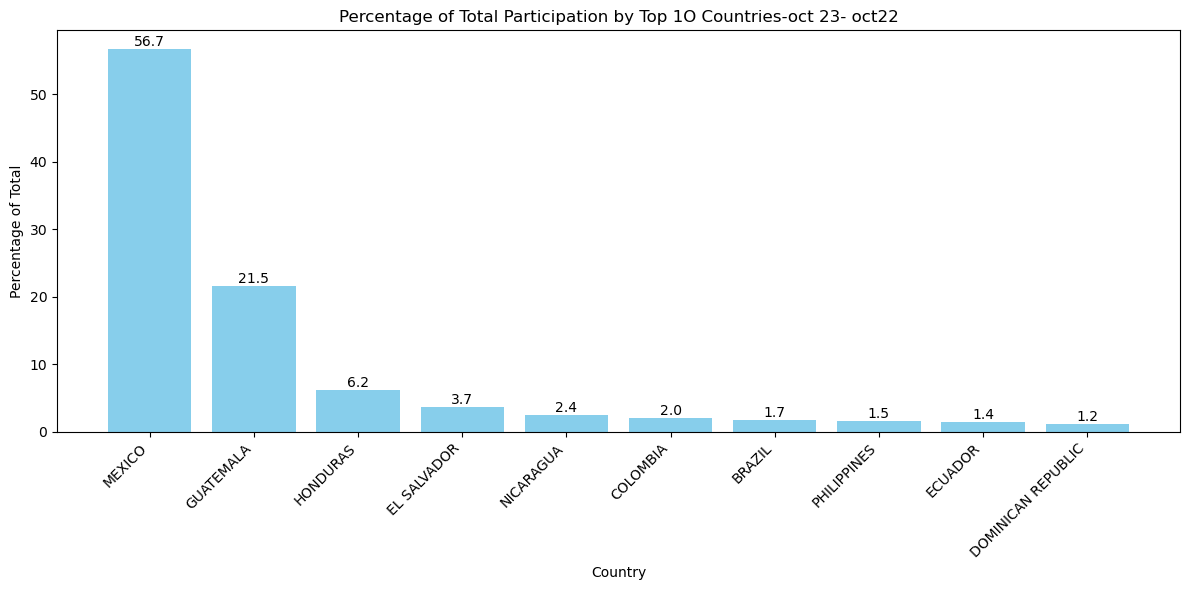

In [169]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_countries['country'], top_10_countries['country_participation'], color='skyblue')
plt.title('Percentage of Total Participation by Top 1O Countries-oct 23- oct22')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
###WE CONTINUE WITH THE ANALYSIS FROM JULY 23 TO JULY 22

In [171]:
##WEIGHT  OF EACH PAYER (01/07/23-01/07/22)##
# Calculate the total amount
total_amount = df_final_last_year_jul['amount'].sum()

# Calculate the participation of each country
df_final_last_year_jul['participation'] = df_final_last_year_jul['amount'] / total_amount

# Group and sum the amount by country
total_amount_per_payer = df_final_last_year_jul.groupby('payer_country')['amount'].sum()

# Get the top 40 payers
top_40_payers = total_amount_per_payer.sort_values(ascending=False).head(40)

# Calculate the percentage of each country relative to the total amount
percentage_of_total = (top_40_payers / total_amount) * 100

# Calculate the cumulative sum of participations
cumulative_participation = percentage_of_total.cumsum()

# Create a DataFrame with the amounts, percentages, and cumulative participations
top_40_df = pd.DataFrame({'amount': top_40_payers, 
                          'percentage_of_total': percentage_of_total,
                          'cumulative_participation': cumulative_participation})

top_40_df['payer_country'] =top_40_df.index
top_40_df['country_name'] = top_40_df['payer_country'].str.split('_').str[1]

#print(top_40_df)

/tmp/ipykernel_339/1899766175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_last_year_jul['participation'] = df_final_last_year_jul['amount'] / total_amount


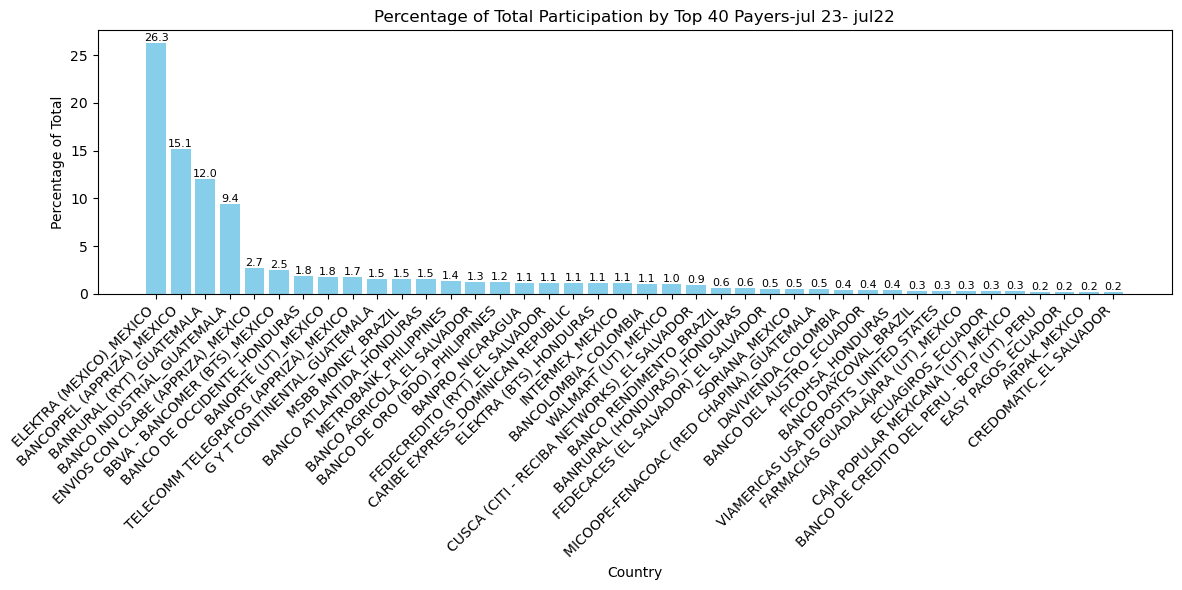

In [172]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_40_df['payer_country'], top_40_df['percentage_of_total'], color='skyblue')
plt.title('Percentage of Total Participation by Top 40 Payers-jul 23- jul22')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=8)

plt.tight_layout()
plt.show()

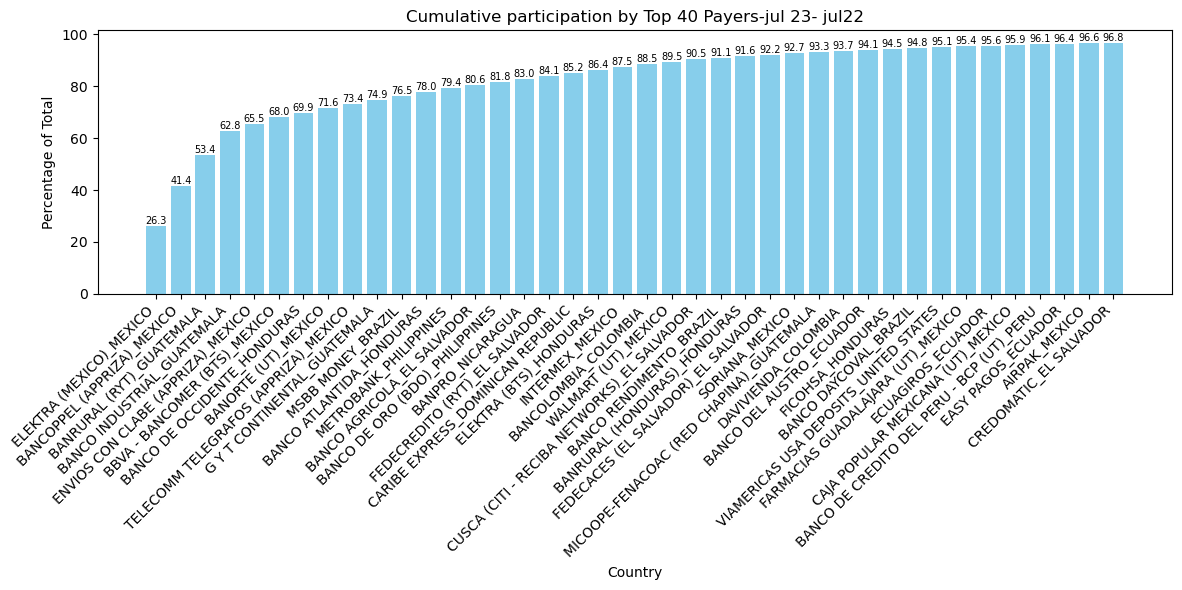

In [173]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_40_df['payer_country'], top_40_df['cumulative_participation'], color='skyblue')
plt.title('Cumulative participation by Top 40 Payers-jul 23- jul22')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=7)

plt.tight_layout()
plt.show()

In [ ]:
##Top 10 countries (jul 23 jul 22)

In [175]:
# Calculate the total amount of business
total_business_amount = df_final_last_year_jul['amount'].sum()

# Calculate the participation of each country
df_final_last_year_jul['country_participation'] = df_final_last_year_jul.groupby('country')['amount'].transform(lambda x: x.sum() / total_business_amount)

# Show the top 10 countries by participation in the business
total_amount_per_country = df_final_last_year_jul.groupby('country')['amount'].sum()
top_10_countries = total_amount_per_country.sort_values(ascending=False).head(10)

# Add the participation of each country in the business to the top_10_countries DataFrame
top_10_countries = pd.DataFrame({'total_amount': top_10_countries,
                                 'country_participation': (top_10_countries / total_business_amount)*100})
top_10_countries['country']=top_10_countries.index

#print(top_10_countries) 

/tmp/ipykernel_339/398685926.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_last_year_jul['country_participation'] = df_final_last_year_jul.groupby('country')['amount'].transform(lambda x: x.sum() / total_business_amount)


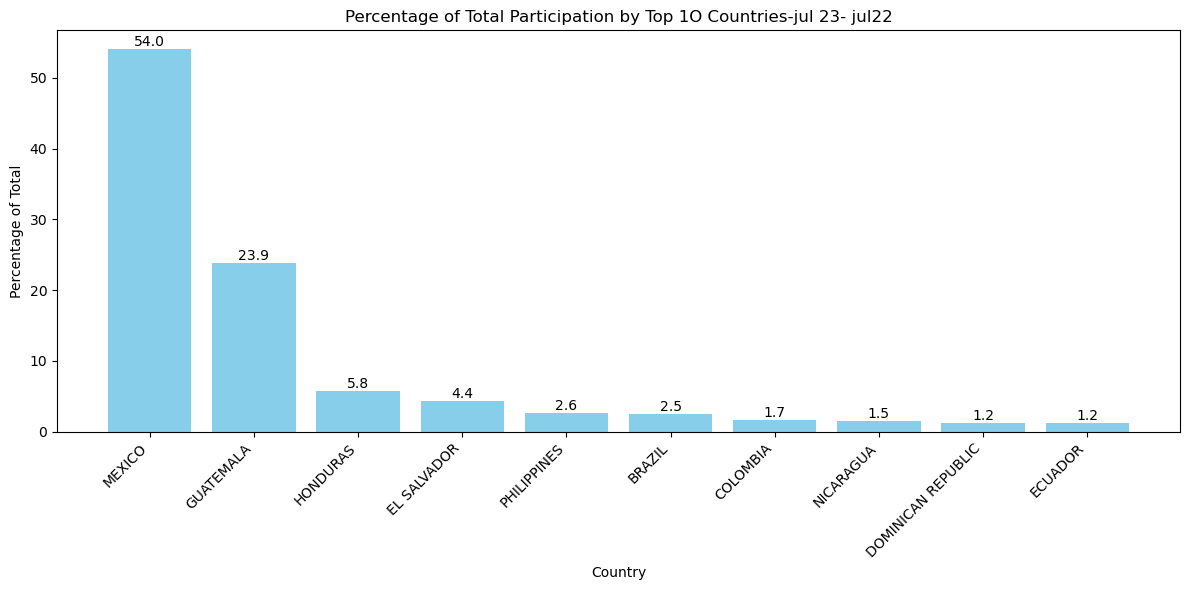

In [176]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_countries['country'], top_10_countries['country_participation'], color='skyblue')
plt.title('Percentage of Total Participation by Top 1O Countries-jul 23- jul22')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
###WE CONTINUE WITH THE ANALYSIS FROM APRIL 23 TO APRIL 22

In [177]:
##WEIGHT  OF EACH PAYER (01/04/23-01/04/22)##
# Calculate the total amount
total_amount = df_final_last_year_apr['amount'].sum()

# Calculate the participation of each country
df_final_last_year_apr['participation'] = df_final_last_year_apr['amount'] / total_amount

# Group and sum the amount by country
total_amount_per_payer = df_final_last_year_apr.groupby('payer_country')['amount'].sum()

# Get the top 40 payers
top_40_payers = total_amount_per_payer.sort_values(ascending=False).head(40)

# Calculate the percentage of each country relative to the total amount
percentage_of_total = (top_40_payers / total_amount) * 100

# Calculate the cumulative sum of participations
cumulative_participation = percentage_of_total.cumsum()

# Create a DataFrame with the amounts, percentages, and cumulative participations
top_40_df = pd.DataFrame({'amount': top_40_payers, 
                          'percentage_of_total': percentage_of_total,
                          'cumulative_participation': cumulative_participation})

top_40_df['payer_country'] =top_40_df.index
top_40_df['country_name'] = top_40_df['payer_country'].str.split('_').str[1]

#print(top_40_df)

/tmp/ipykernel_339/173026205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_last_year_apr['participation'] = df_final_last_year_apr['amount'] / total_amount


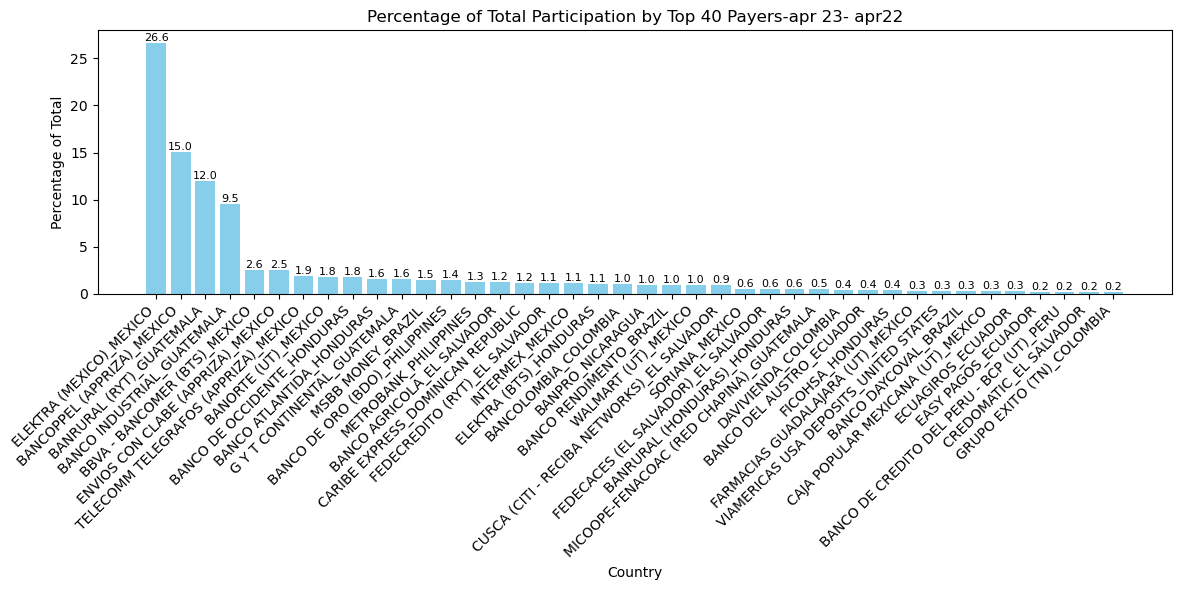

In [178]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_40_df['payer_country'], top_40_df['percentage_of_total'], color='skyblue')
plt.title('Percentage of Total Participation by Top 40 Payers-apr 23- apr22')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=8)

plt.tight_layout()
plt.show()

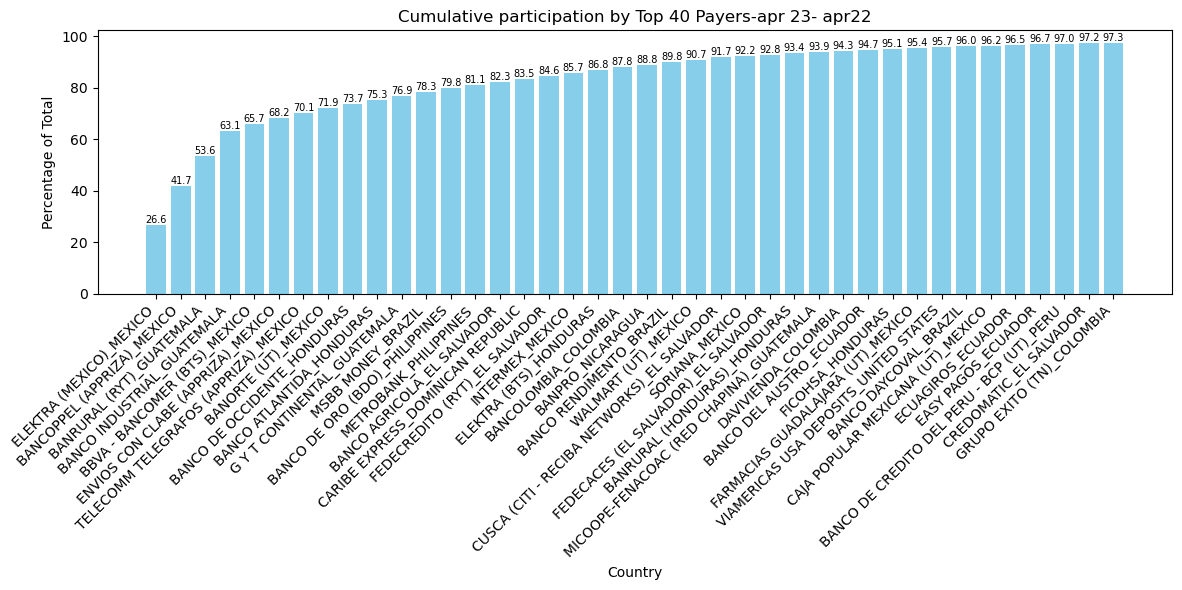

In [179]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_40_df['payer_country'], top_40_df['cumulative_participation'], color='skyblue')
plt.title('Cumulative participation by Top 40 Payers-apr 23- apr22')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=7)

plt.tight_layout()
plt.show()

In [ ]:
##Top 10 countries apr23 apr22

In [180]:
# Calculate the total amount of business
total_business_amount = df_final_last_year_apr['amount'].sum()

# Calculate the participation of each country
df_final_last_year_apr['country_participation'] = df_final_last_year_apr.groupby('country')['amount'].transform(lambda x: x.sum() / total_business_amount)

# Show the top 10 countries by participation in the business
total_amount_per_country = df_final_last_year_apr.groupby('country')['amount'].sum()
top_10_countries = total_amount_per_country.sort_values(ascending=False).head(10)

# Add the participation of each country in the business to the top_10_countries DataFrame
top_10_countries = pd.DataFrame({'total_amount': top_10_countries,
                                 'country_participation': (top_10_countries / total_business_amount)*100})
top_10_countries['country']=top_10_countries.index

#print(top_10_countries) 

/tmp/ipykernel_339/210242572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_last_year_apr['country_participation'] = df_final_last_year_apr.groupby('country')['amount'].transform(lambda x: x.sum() / total_business_amount)


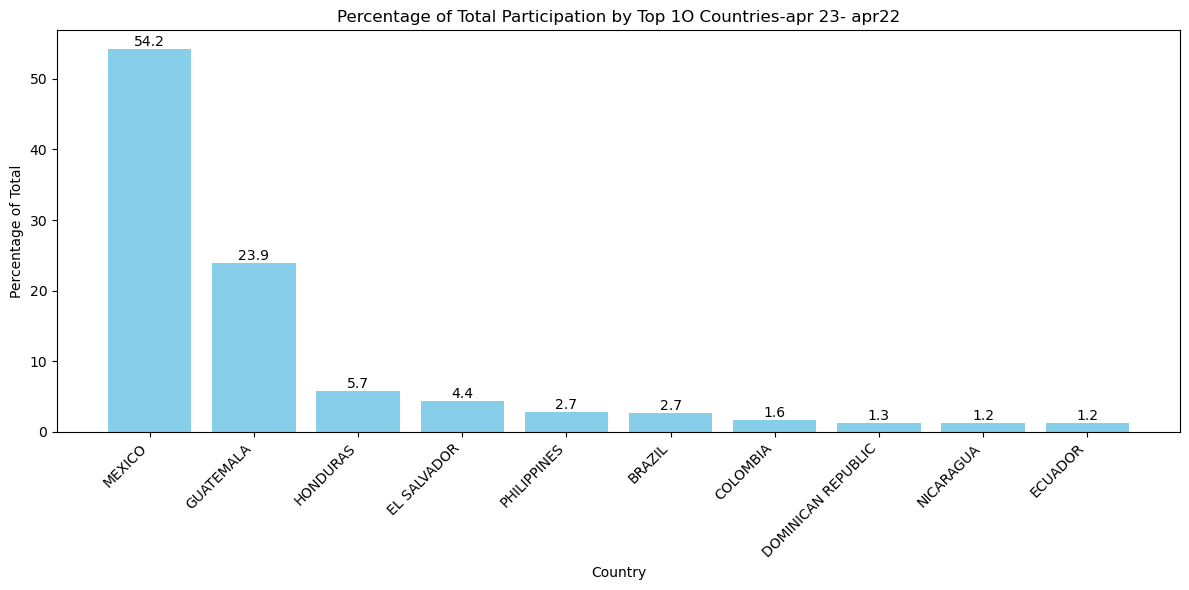

In [181]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_countries['country'], top_10_countries['country_participation'], color='skyblue')
plt.title('Percentage of Total Participation by Top 1O Countries-apr 23- apr22')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=10)

plt.tight_layout()
plt.show()